In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from similarity_searching_sketches.stat_utils import interpret_corr_result
from similarity_searching_sketches.persistence import load_np_array
from similarity_searching_sketches.persistence import save_np_array
from similarity_searching_sketches.partitioning import assign_ghp_partition
from similarity_searching_sketches.partitioning import balance_score
from similarity_searching_sketches.visualization import plot_array
from similarity_searching_sketches.log_utils import IterationLogger

In [2]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
PIVOT_CAND_SAVE_FILE=DATA_FOLDER+'pivot_candidates.npy' #where to save array of pivot couple candidates sorted by balance score
BALANCE_SCORES_SAVE_FILE=DATA_FOLDER+'balance_scores.npy' #where to save array of balance scores of pivot candidate couples
HP_DISTANCES_SAVE_FILE=DATA_FOLDER+'hp_distances.npy' #where to save mean distances of objects to dividing hyperplane
SKETCH_MATRIX_SAVE_FILE=DATA_FOLDER+'sketch_matrix.npy' #where to save Sketch Matrix to
TRAIN_SET_PATH=DATA_FOLDER+'train_set.npy' #read Training set from
N_PIVOT_CANDIDATE_COUPLES=1000 #How many pivot couples to randomly select
LOG_BY=1000 #Log iterations by

#### Load Training set

In [3]:
vecs=load_np_array(TRAIN_SET_PATH)

In [4]:
vecs.shape

(8000, 4096)

#### Balance score function visualization

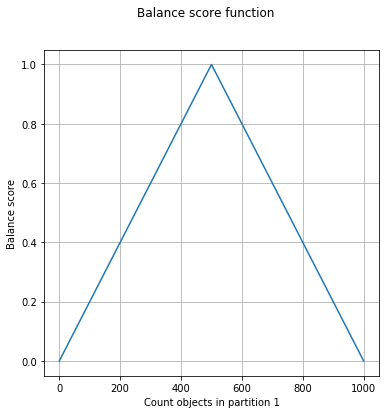

In [5]:
plot_array([balance_score(float(num),float(1000)) for num in range(0,1001)], title='Balance score function',xlabel='Count objects in partition 1',ylabel='Balance score',figsize=(6,6))

#### Select random pivot couples as pivot candidates

In [6]:
rand_indices=np.random.choice(vecs.shape[0], size=N_PIVOT_CANDIDATE_COUPLES*2, replace=False)

In [7]:
pivot_cand=np.array(list(zip(*np.split(vecs[rand_indices],2)))) #get pivot candidate couples

In [8]:
pivot_cand.shape

(1000, 2, 4096)

#### Assign partitions to objects and compute distances

In [9]:
sketches=sketch_set.T[:sketch_size].Tsketch_matrix=np.zeros(shape=(vecs.shape[0], N_PIVOT_CANDIDATE_COUPLES))
partition_one_cnts=np.zeros(N_PIVOT_CANDIDATE_COUPLES)
sum_distances_from_hp=np.zeros(N_PIVOT_CANDIDATE_COUPLES)

In [10]:
logger=IterationLogger(log_by=LOG_BY)
for i, vec in enumerate(vecs):
    logger.next_iter()
    for j, (pivot_a, pivot_b) in enumerate(pivot_cand):
        partition, dist=assign_ghp_partition(vec, pivot_a, pivot_b, distance_to_hp=True)
        sketch_matrix[i][j]=partition
        sum_distances_from_hp[j]+=dist
        if partition==1:
            partition_one_cnts[j]+=1
        

INFO:IterationLogger| Started iteration no.: 1000
 Time from previous iteration: 67.20287251472473s
 Time from start: 67.20287275314331s
INFO:IterationLogger| Started iteration no.: 2000
 Time from previous iteration: 68.11888837814331s
 Time from start: 135.32176184654236s
INFO:IterationLogger| Started iteration no.: 3000
 Time from previous iteration: 65.93389320373535s
 Time from start: 201.25565576553345s
INFO:IterationLogger| Started iteration no.: 4000
 Time from previous iteration: 66.24572682380676s
 Time from start: 267.5013835430145s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 66.11560344696045s
 Time from start: 333.61698746681213s
INFO:IterationLogger| Started iteration no.: 6000
 Time from previous iteration: 64.32960367202759s
 Time from start: 397.94659185409546s
INFO:IterationLogger| Started iteration no.: 7000
 Time from previous iteration: 64.46055674552917s
 Time from start: 462.40714931488037s
INFO:IterationLogger| Started iterat

#### Distances from dividing hyperplane

In [11]:
mean_distances=sum_distances_from_hp/vecs.shape[0]

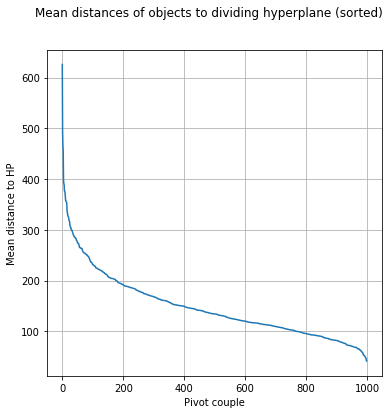

In [12]:
plot_array(sorted(mean_distances,reverse=True), title='Mean distances of objects to dividing hyperplane (sorted)',xlabel='Pivot couple',ylabel='Mean distance to HP',figsize=(6,6))

#### Compute Balance scores
Larger balance score is better.

In [13]:
balance_scores=np.array([balance_score(cnt_part, vecs.shape[0]) for cnt_part in partition_one_cnts])

In [14]:
pd.DataFrame(balance_scores).describe()

,0
count,1000.000000
mean,0.465884
std,0.299802
min,0.000500
25%,0.191437
50%,0.463000
75%,0.714000
max,1.000000


In [15]:
sorted_args=np.argsort(balance_scores)[::-1]
balance_scores_sorted=balance_scores[sorted_args]
pivot_cand_sorted=pivot_cand[sorted_args]
sketch_matrix_sorted=sketch_matrix[:,sorted_args]

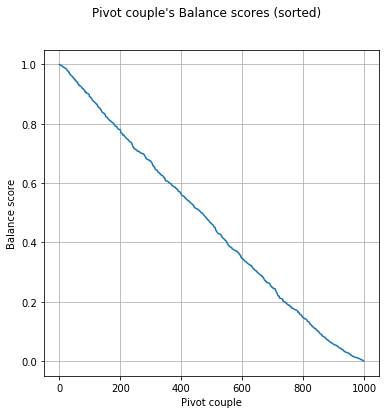

In [16]:
plot_array(balance_scores_sorted, title='Pivot couple\'s Balance scores (sorted)',xlabel='Pivot couple',ylabel='Balance score',figsize=(6,6))

#### Correlation between balance score and distance from dividing hyperplane

In [17]:
mean_hp_distances_sorted=mean_distances[sorted_args]

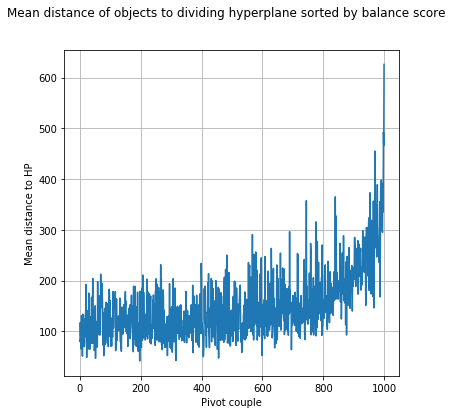

In [18]:
plot_array(mean_hp_distances_sorted, title='Mean distance of objects to dividing hyperplane sorted by balance score',xlabel='Pivot couple',ylabel='Mean distance to HP',figsize=(6,6))

In [19]:
corr,pval=spearmanr(balance_scores_sorted, b=mean_hp_distances_sorted)

In [20]:
corr

-0.54009593653050869

In [21]:
pval

8.4341776677293437e-77

In [22]:
interpret_corr_result(corr,pval)

Computed correlation -0.540095936531 which can be interpreted as moderate negative linear dependence is statistically significant on confidence interval [0.95,1].


#### Persist pivots, their balance scores and distances from HP sorted by balance score

In [23]:
save_np_array(PIVOT_CAND_SAVE_FILE, pivot_cand_sorted)
save_np_array(BALANCE_SCORES_SAVE_FILE, balance_scores_sorted)
save_np_array(HP_DISTANCES_SAVE_FILE, mean_hp_distances_sorted)
save_np_array(SKETCH_MATRIX_SAVE_FILE, sketch_matrix_sorted)